<a href="https://colab.research.google.com/github/zhulkhoirr/Steam-Recommendation-System/blob/main/SteamRecommendationSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistem Rekomendasi Game Pada Platform Steam

## 1. Download Datasets Dari Kaggle

In [ ]:
from google.colab import files
files.upload()

In [3]:
!pip install -q kaggle

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d antonkozyriev/game-recommendations-on-steam

Dataset URL: https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam
License(s): CC0-1.0
100% 660M/660M [00:39<00:00, 19.9MB/s]
100% 660M/660M [00:39<00:00, 17.4MB/s]


In [7]:
!unzip -q game-recommendations-on-steam.zip

## 2. Memahami Data

In [8]:
import numpy as np
import pandas as pd

In [9]:
recommendations_df = pd.read_csv('recommendations.csv')

recommendations_df.sample(5)

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
17557776,359550,0,0,2016-11-11,False,844.5,1861039,17557776
12538667,1273400,0,0,2022-09-25,True,48.8,7451775,12538667
11504941,747610,2,0,2021-11-05,True,501.9,8186558,11504941
1124200,250900,0,0,2021-09-28,True,165.6,7663569,1124200
33915697,255710,0,0,2021-05-29,True,8.7,1734759,33915697


## 3. Mempersiapkan Data

In [10]:
recommendations_df = pd.read_csv('recommendations.csv', usecols=['app_id', 'is_recommended', 'user_id', 'hours'])

recommendations_df.head(5)

,app_id,is_recommended,hours,user_id
0,975370,True,36.3,51580
1,304390,False,11.5,2586
2,1085660,True,336.5,253880
3,703080,True,27.4,259432
4,526870,True,7.9,23869


In [11]:
hours_count = recommendations_df[recommendations_df['hours'] == 0.0].count()

print(f"Jumlah nilai 0.0 di kolom 'hours': {hours_count['hours']}")

Jumlah nilai 0.0 di kolom 'hours': 176329


In [12]:
recommendations_df = recommendations_df[recommendations_df['hours'] != 0.0]

In [13]:
zero_hours_count = (recommendations_df['hours'] == 0.0).sum()

print(f"Jumlah nilai 0.0 di kolom 'hours': {zero_hours_count}")

Jumlah nilai 0.0 di kolom 'hours': 0


In [14]:
n_recommendations = recommendations_df['user_id'].value_counts()
print(n_recommendations)

user_id
11764552    5652
5112758     3657
11656130    3648
5669734     3479
11553593    3118
            ... 
13054906       1
3408492        1
6467985        1
4722185        1
4225275        1
Name: count, Length: 13760373, dtype: int64


In [15]:
n_recommendations = recommendations_df['user_id'].value_counts()
recommendations_df = recommendations_df[recommendations_df['user_id'].isin(n_recommendations[n_recommendations >=50].index)].copy()
recommendations_df.head(5)

,app_id,is_recommended,hours,user_id
58,602960,True,41.9,737481
138,570940,False,73.3,5136277
151,1196590,True,19.0,5935019
203,304390,False,42.5,10567745
209,244850,True,540.7,11143713


In [16]:
print("Jumlah duplikasi:",  recommendations_df.duplicated().sum())

Jumlah duplikasi: 1


In [17]:
recommendations_df.drop_duplicates(inplace=True)
print("Jumlah duplikasi:",  recommendations_df.duplicated().sum())

Jumlah duplikasi: 0


In [18]:
recommendations_df.isnull().sum()

app_id            0
is_recommended    0
hours             0
user_id           0
dtype: int64

In [19]:
recommendations_df['is_recommended'] = recommendations_df['is_recommended'].astype(int)

## 4. Preprocessing Data

In [20]:
user_ids = recommendations_df['user_id'].unique().tolist()
user2user_encoded = {x:i for i, x in enumerate(user_ids)}
user_encoded2user = {i:x for i, x in enumerate(user_ids)}
recommendations_df['user'] = recommendations_df['user_id'].map(user2user_encoded)
n_users = len(user2user_encoded)

app_ids = recommendations_df['app_id'].unique().tolist()
app2app_encoded = {x:i for i, x in enumerate(app_ids)}
app_encoded2app = {i:x for i, x in enumerate(app_ids)}
recommendations_df['app'] = recommendations_df['app_id'].map(app2app_encoded)
n_app  = len(app2app_encoded)

print("Jumlah user: {}, Jumlah game: {}".format(n_users, n_app))

Jumlah user: 36646, Jumlah game: 36028


In [21]:
recommendations_df

,app_id,is_recommended,hours,user_id,user,app
58,602960,1,41.9,737481,0,0
138,570940,0,73.3,5136277,1,1
151,1196590,1,19.0,5935019,2,2
203,304390,0,42.5,10567745,3,3
209,244850,1,540.7,11143713,4,4
...,...,...,...,...,...,...
41154764,1818450,1,1.0,13261742,24873,991
41154770,700600,1,2.0,6382076,35046,2837
41154771,362960,1,35.0,7858713,21437,3024
41154784,633230,0,20.0,8107668,18148,2391


In [22]:
recommendations_df = recommendations_df.sample(frac=1, random_state=46)

X = recommendations_df[['user', 'app']].values
y = recommendations_df['is_recommended']

In [23]:
X

array([[ 8127,    52],
       [ 5147, 27858],
       [ 6385,  2674],
       ...,
       [30719,  1078],
       [ 7675,   401],
       [23746, 25712]])

In [24]:
y

13131890    1
35625112    1
16695870    1
14523913    1
6006244     1
           ..
3402980     0
36455208    1
9328930     0
19537234    1
36598476    0
Name: is_recommended, Length: 3376881, dtype: int64

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

print("Train set is_recommended: {}".format(len(y_train)))
print("Test set is_recommended: {}".format(len(y_test)))

Train set is_recommended: 2701504
Test set is_recommended: 675377


In [26]:
X_train

array([[29438,  3890],
       [ 3727, 23255],
       [   55,   745],
       ...,
       [  991, 27745],
       [35784, 27875],
       [25174,  1776]])

In [27]:
X_train[:, 0]

array([29438,  3727,    55, ...,   991, 35784, 25174])

In [28]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [29]:
X_train_array

[array([29438,  3727,    55, ...,   991, 35784, 25174]),
 array([ 3890, 23255,   745, ..., 27745, 27875,  1776])]

## 5. Membuat Model

In [30]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout, Dot, BatchNormalization

def RecommenderNet(n_users, n_app, embedding_size=32):
  user_input = Input(shape=(1), name='user')
  user_embedding = Embedding(n_users, embedding_size, name='user_embedding')(user_input)
  app_input = Input(shape=(1), name='app')
  app_embedding = Embedding(n_app, embedding_size, name='app_embedding')(app_input)

  # concatenate = Concatenate(name='concatenate')([user_vec, app_vec])
  dot = Dot(axes=1, normalize=True, name='dot')([user_embedding, app_embedding])
  flatten = Flatten(name='flatten')(dot)

  dense = Dense(128, activation='relu', name='dense')(flatten)
  dropout = Dropout(0.4, name='dropout')(dense)
  batch_norm = BatchNormalization(name='batch_norm')(dropout)
  output = Dense(1, activation='sigmoid', name='output')(batch_norm)

  model = Model([user_input, app_input], output)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mae', 'mse'])

  return model

model = RecommenderNet(n_users, n_app)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 app (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 32)                1172672   ['user[0][0]']                
                                                                                                  
 app_embedding (Embedding)   (None, 1, 32)                1152896   ['app[0][0]']                 
                                                                                              

In [31]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    epochs=15,
    batch_size=256,
    validation_data=(X_test_array, y_test)
)

Epoch 1/15
10553/10553 [==============================] - 111s 10ms/step - loss: 0.4965 - mae: 0.3158 - mse: 0.1583 - val_loss: 0.4901 - val_mae: 0.3120 - val_mse: 0.1560
Epoch 2/15
10553/10553 [==============================] - 93s 9ms/step - loss: 0.4874 - mae: 0.3098 - mse: 0.1550 - val_loss: 0.4864 - val_mae: 0.3138 - val_mse: 0.1547
Epoch 3/15
10553/10553 [==============================] - 92s 9ms/step - loss: 0.4832 - mae: 0.3071 - mse: 0.1536 - val_loss: 0.4838 - val_mae: 0.3075 - val_mse: 0.1538
Epoch 4/15
10553/10553 [==============================] - 92s 9ms/step - loss: 0.4799 - mae: 0.3049 - mse: 0.1525 - val_loss: 0.4819 - val_mae: 0.3061 - val_mse: 0.1532
Epoch 5/15
10553/10553 [==============================] - 91s 9ms/step - loss: 0.4772 - mae: 0.3032 - mse: 0.1516 - val_loss: 0.4807 - val_mae: 0.3082 - val_mse: 0.1528
Epoch 6/15
10553/10553 [==============================] - 95s 9ms/step - loss: 0.4749 - mae: 0.3017 - mse: 0.1508 - val_loss: 0.4794 - val_mae: 0.2992 - 

In [32]:
loss, mae, mse = model.evaluate(X_test_array, y_test)

print(f'Loss: {loss}, MAE: {mae}, MSE: {mse}')

21106/21106 [==============================] - 80s 4ms/step - loss: 0.4701 - mae: 0.2914 - mse: 0.1492
Loss: 0.4701184630393982, MAE: 0.2914051115512848, MSE: 0.14915893971920013


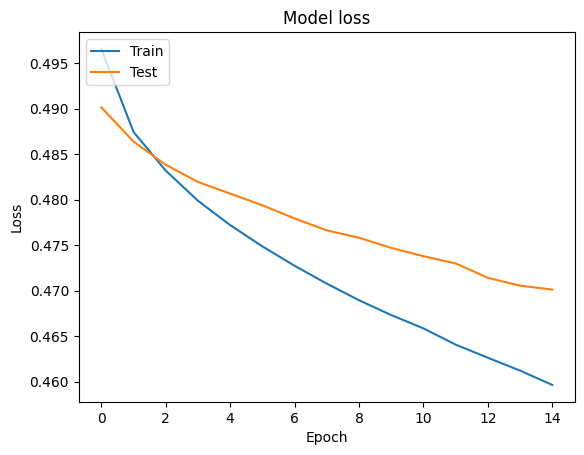

In [33]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [34]:
model.save('model/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Metadata Game Steam

In [35]:
games_df = pd.read_csv('games.csv')

games_df.sample(5)

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
29632,258541,Heat Wave DLC - Kenji's pack,2013-10-30,True,False,False,Mixed,61,13,0.99,0.99,0.0,True
31511,1753524,Beat Saber: Billie Eilish - 'Happier Than Ever',2021-09-21,True,False,False,Mostly Negative,28,14,1.99,1.99,0.0,True
35625,1202710,Santa's Christmas Solitaire 2,2019-12-14,True,False,False,Positive,100,15,4.99,4.99,0.0,True
26382,556280,Neon Prism,2016-11-18,True,True,False,Mostly Positive,72,184,10.99,10.99,0.0,True
24213,696590,XXZ: XXL,2017-09-29,True,False,False,Mostly Positive,79,192,5.99,5.99,0.0,True


In [41]:
sorted_df = games_df.sort_values(by='user_reviews', ascending=False).head(10)

sorted_df

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
14398,730,Counter-Strike: Global Offensive,2012-08-21,True,True,True,Very Positive,88,7494460,15.0,0.0,0.0,True
47770,578080,PUBG: BATTLEGROUNDS,2017-12-21,True,False,False,Mixed,57,2217226,0.0,0.0,0.0,True
13176,570,Dota 2,2013-07-09,True,True,True,Very Positive,82,2045628,0.0,0.0,0.0,True
12717,271590,Grand Theft Auto V,2015-04-13,True,False,False,Very Positive,86,1484122,0.0,0.0,0.0,True
14535,359550,Tom Clancy's Rainbow Six® Siege,2015-12-01,True,False,False,Very Positive,86,993312,20.0,0.0,0.0,True
47380,440,Team Fortress 2,2007-10-10,True,True,True,Very Positive,93,985819,0.0,0.0,0.0,True
13035,105600,Terraria,2011-05-16,True,True,True,Overwhelmingly Positive,97,943413,10.0,0.0,0.0,True
15363,4000,Garry's Mod,2006-11-29,True,True,True,Overwhelmingly Positive,96,853733,10.0,0.0,0.0,True
13173,252490,Rust,2018-02-08,True,True,False,Very Positive,87,786668,40.0,0.0,0.0,True
14376,1172470,Apex Legends™,2020-11-04,True,False,False,Very Positive,80,713182,0.0,0.0,0.0,True


In [36]:
import json

with open('games_metadata.json', 'r') as file:
    data = file.read()

json_objects = data.split('\n')

data_list = []
for obj in json_objects:
    if obj.strip():
        data_list.append(json.loads(obj))

games_metadata_df = pd.DataFrame(data_list)
games_metadata_df['tags'] = games_metadata_df['tags'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
games_metadata_df.sample(5)


,app_id,description,tags
37931,406610,,"Action, Adventure"
46083,2261750,A combination of Tower Defense and Rogue-like ...,"Roguelike Deckbuilder, Tower Defense, Class-Ba..."
17331,1853450,,"Indie, Casual, Simulation"
35908,1587020,Parapsychology is a co-op horror game that can...,"Early Access, Adventure, Action, Casual, Puzzl..."
49162,2224461,,"Action, Adventure"


In [37]:
gg = games_metadata_df[games_metadata_df['app_id'] == 409710]

gg

,app_id,description,tags
25126,409710,"BioShock is a shooter unlike any other, loaded...","FPS, Story Rich, Atmospheric, Horror, Singlepl..."


In [38]:
games_with_metadata_df = pd.merge(games_df, games_metadata_df, on='app_id', how='outer')

selected_columns = ['app_id', 'title', 'rating', 'user_reviews', 'final_price', 'description', 'tags']

games_with_metadata_df = games_with_metadata_df[selected_columns]

games_with_metadata_df.sample(5)

,app_id,title,rating,user_reviews,price_original,description,tags
16172,222520,Champions of Regnum,Mixed,1101,0.00,Choose your Realm and engage in the most dynam...,"Free to Play, RPG, Massively Multiplayer, MMOR..."
44928,2159920,Lion King Simulator,Positive,14,10.99,"In this hunting simulator, you will play the r...","Action, Adventure, Casual, Simulation, Choose ..."
13134,1397490,Total Tank Simulator - Italy DLC,Mostly Positive,64,4.99,,"Action, Indie, Simulation, Strategy"
26722,1010440,电竞俱乐部故事模式1/ESports Club Story1,Mixed,31,0.00,,"Free to Play, RPG, Indie, Simulation"
8415,1698080,Club Soccer Director 2022,Mostly Positive,86,0.00,Take control of a Real Football Club or create...,"Simulation, Sports, Strategy, Immersive Sim, R..."


In [39]:
filtered_df = games_with_metadata_df[selected_columns]

sorted_df = filtered_df.sort_values(by='user_reviews', ascending=False).head(10)

sorted_df

,app_id,title,rating,user_reviews,price_original,description,tags
14398,730,Counter-Strike: Global Offensive,Very Positive,7494460,0.0,,
47770,578080,PUBG: BATTLEGROUNDS,Mixed,2217226,0.0,,
13176,570,Dota 2,Very Positive,2045628,0.0,,
12717,271590,Grand Theft Auto V,Very Positive,1484122,0.0,,
14535,359550,Tom Clancy's Rainbow Six® Siege,Very Positive,993312,0.0,,
47380,440,Team Fortress 2,Very Positive,985819,0.0,,
13035,105600,Terraria,Overwhelmingly Positive,943413,0.0,,
15363,4000,Garry's Mod,Overwhelmingly Positive,853733,0.0,,
13173,252490,Rust,Very Positive,786668,0.0,,
14376,1172470,Apex Legends™,Very Positive,713182,0.0,,


In [40]:
users_df = pd.read_csv('users.csv')

users_df.sample(5)

,user_id,products,reviews
9696586,8879395,50,5
4422252,209891,33,2
2047711,9680032,46,1
11947222,2245421,35,1
8118354,7693898,97,10


In [43]:
print('Pilih user random')

recommendation_per_user = recommendations_df.groupby('user_id').size()

random_user =  recommendation_per_user[recommendation_per_user > 50].sample(1).index[0]

print(f'user_id: {random_user}')

Pilih user random
User: 9563740


In [44]:
print(f'Game yang direkomendasikan untuk user:  {random_user}')
print('===' * 25)

game_played_by_user = recommendations_df[recommendations_df.user_id == random_user]

game_played_by_user

Game yang direkomendasikan untuk user:  9563740


,app_id,is_recommended,hours,user_id,user,app
33097367,252470,1,420.4,9563740,19156,23220
29211617,1054510,1,2.4,9563740,19156,21778
32147283,465490,1,1.3,9563740,19156,24474
12163033,611660,1,28.0,9563740,19156,235
33333384,239840,1,118.1,9563740,19156,25713
18281790,2600,1,248.1,9563740,19156,586
18503911,582160,1,83.7,9563740,19156,628
31594992,378540,0,5.7,9563740,19156,24223
33350107,706020,1,52.8,9563740,19156,25052
35816082,445190,1,33.6,9563740,19156,27883
